In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import matplotlib.pyplot as plt
import yaml


from models.model2 import BicycleModel
from models.model4 import FourWheelModel
from models.utils import fit_circle
from models.utils import plot_column_histograms

In [3]:
np.random.seed(100)
class Param_Inferencer:
    def __init__(self) -> None:
        # List of parameters to infer
        self.list_of_param = ['T_peak', 'T_slope']
        # Number of paramters to infer
        self.param_to_infer = len(self.list_of_param)
        # Sample vector
        self.thetas = np.random.rand(self.param_to_infer + 1).reshape(1,-1) # First one is random + likelihood
        # Burnin
        self.burnin = None

        # Current model and model parameters
        self.model = None
        self.dt = 0.05
        self.open_loop_tf = 50
        # T_peak and T_slope is not specified since we infer those
        # Load the CSV file using numpy.genfromtxt()
        data = np.genfromtxt('./Data/Data_Bicycle/radiuses.csv', delimiter=',', names=True, dtype=None)
        self.y_likelihood = data['R']
    



    def get_circle_radius(self, tetha):
        '''
            Gets the radius of  the circle from the open loop simulation
            @param name_of-param
        '''
        # Generate the right tyre1000.yaml file (Let's call it 1000 by convention)
        self.generate_new_model(tetha[:self.param_to_infer])
        
        # Generate the new data
        t0 = 0
        N = self.model.open_loop_tf/self.model.dt
        steering = 0.2
        torque = 1000
        inputs = [steering, torque, torque, torque, torque]
        t,x_vect = self.model.do_open_loop_sim_cst_inputs(t0, inputs)
        
        # Fetch the radius from the data
        x = x_vect[int(N/2):,0]
        y = x_vect[int(N/2):,1]
        radius = fit_circle(x, y) 
        
        return radius
    
    def generate_new_model(self, Tetha):
        T_peak = Tetha[0]
        T_slope = Tetha[1]
        self.model = BicycleModel( self.dt, self.open_loop_tf,float(T_peak), float(T_slope))

    #----------------- Functions from here take care of the inference -----------------#

    def proposal(self, prec_theta, search_width = 0.5):
        # this function generates the proposal for the new theta
        # we assume that the distribution of the random variables 
        # is normal for the first two and gamma for the third.
        # conditional on the previous value of the accepted parameters (prec_theta)
        out_theta = np.zeros(self.param_to_infer+1)
        out_theta[:self.param_to_infer] = sc.multivariate_normal(mean=prec_theta[:self.param_to_infer],cov=np.eye(self.param_to_infer)*search_width**2).rvs(1)
        #the last component is the noise
        out_theta[self.param_to_infer] = sc.gamma(a=prec_theta[self.param_to_infer]*search_width*500, scale=1/(500*search_width)).rvs()
        return out_theta
    
    def log_likelihood(self, tetha):
        proposed_radius = self.get_circle_radius(tetha)
        mean = np.full(self.y_likelihood.shape[0], proposed_radius).reshape(-1,1)
        log_likelihood_vect = sc.norm.logpdf(self.y_likelihood, loc= mean, scale=tetha[self.param_to_infer]) # Loc will be simulation(theta(:param_to_infer), scale = theta[param_to_infer])
        log_likelihood_out = np.sum(log_likelihood_vect)
        return log_likelihood_out

    def log_prior(self, theta):
        # evaluate the prior for the parameters on a multivariate gaussian. 
        prior_out = sc.multivariate_normal.logpdf(theta[:self.param_to_infer],mean=np.zeros(self.param_to_infer), cov=np.eye(self.param_to_infer)*100)
        # this needs to be summed to the prior for the sigma, since I assumed independence.
        prior_out += sc.gamma.logpdf(theta[self.param_to_infer], a=1, scale=1)
        return prior_out


    def log_proposal_x_given_y(self, x,y, search_width = 10):
        walk = 1
        # Parameters
        log_proposal_param = sc.multivariate_normal.logpdf(x[:self.param_to_infer],mean=y[:self.param_to_infer], cov=np.eye(self.param_to_infer)*search_width**2)
        # Standard deviation
        log_proposal_std_dev = sc.gamma.logpdf(x[self.param_to_infer], a=y[self.param_to_infer]*walk*500, scale=1/(500*walk))
        
        log_proposal_x_given_y = log_proposal_param+log_proposal_std_dev
        return log_proposal_x_given_y

    def acceptance_prob(self, log_likelihood_theta, log_likelihood_theta_new, log_prior_theta, log_prior_theta_new, log_proposal_theta_given_theta_new, log_proposal_theta__new_given_theta):
        prop_ratio = log_proposal_theta_given_theta_new-log_proposal_theta__new_given_theta
        likelihood_prior_proposal_ratio = -log_likelihood_theta_new + log_likelihood_theta - \
                                log_prior_theta_new + log_prior_theta - prop_ratio
        return np.exp(likelihood_prior_proposal_ratio)

    def inference(self):
        # Number of samples accepted/rejected
        accepted = 0
        rejected = 0
        # Number of iterations
        iter = 650
        # Scale facter of the covariance matrix
        width = 0.01
        
        accepted_thetas = np.full(self.param_to_infer + 1, 0.5).reshape(1,-1) #np.random.rand(self.param_to_infer + 1).reshape(1,-1)
        rejected_thetas = np.empty(self.param_to_infer + 1).reshape(1,-1)
        all_thetas = np.concatenate((accepted_thetas, np.zeros((accepted_thetas.shape[0], 1))), axis=1)
        # Loop for the inference
        for i in range(iter):
            # 1) Provide a proposal for theta
            theta_new = self.proposal(accepted_thetas[-1,:], search_width=width)

            # 2) Compute log-likelihood of the new theta and the old one
            log_likelihood_theta = self.log_likelihood(accepted_thetas[-1,:])
            log_likelihood_theta_new = self.log_likelihood(theta_new)

            # 3) Compute log-prior of the new theta and the old one
            log_prior_theta = self.log_prior(accepted_thetas[-1,:])
            log_prior_theta_new = self.log_prior(theta_new)

            # 4) Compute log-proposal of the new theta and the old one
            log_proposal_theta_given_theta_new = self.log_proposal_x_given_y(accepted_thetas[-1,:], theta_new, search_width =width)
            log_proposal_theta__new_given_theta = self.log_proposal_x_given_y(theta_new, accepted_thetas[-1,:], search_width =width)

            # 5) Compute the acceptance probability
            alpha = self.acceptance_prob(log_likelihood_theta, log_likelihood_theta_new, log_prior_theta, log_prior_theta_new, log_proposal_theta_given_theta_new, log_proposal_theta__new_given_theta)

            #6) Generate a uniform number u from [0,1]
            '''u = sc.uniform().rvs()
            # if u <= alpha, accept the new sample
            if u <= alpha:
                thetas = np.vstack((thetas,theta_new))
                accepted += 1
            else:
                rejected += 1''' 
            u = sc.uniform().rvs()
            if alpha <= u:
                accepted_thetas = np.vstack((accepted_thetas,theta_new))
                accepted += 1
                theta_new_all_thetas = np.hstack((theta_new, np.array([1]).reshape(-1,)))
            else:
                rejected_thetas = np.vstack((rejected_thetas,theta_new))
                rejected += 1
                theta_new_all_thetas = np.hstack((theta_new, np.array([0]).reshape(-1,)))
            
            all_thetas = np.vstack((all_thetas,theta_new_all_thetas))

            if i%50 == 0:
                print(f"Iteration {i}: {accepted} accepted, {rejected} rejected")
        
        return accepted_thetas, rejected_thetas, all_thetas

In [4]:
PI = Param_Inferencer()

accepted_thetas, rejected_thetas, all_thetas = PI.inference()

/var/folders/mw/9cttllqs2yv0dqrlc62m0l8h0000gn/T/ipykernel_33344/1071962660.py:95: RuntimeWarning: overflow encountered in exp
  return np.exp(likelihood_prior_proposal_ratio)


Iteration 0: 0 accepted, 1 rejected


In [36]:
accepted_thetas

array([[0.5       , 0.5       ],
       [0.50981321, 0.60302758],
       [0.50791825, 0.62429014],
       [0.50333798, 0.71593773],
       [0.5195278 , 1.37829157],
       [0.52137298, 1.8524983 ],
       [0.51380946, 2.31956121],
       [0.49767368, 3.39133469],
       [0.49876231, 3.75618282],
       [0.5048927 , 4.35874733],
       [0.48648082, 4.64028219],
       [0.47081394, 5.49488984],
       [0.45540778, 7.85224166],
       [0.44323524, 7.59097678],
       [0.42815939, 7.65743207],
       [0.42199309, 8.570474  ],
       [0.41879478, 7.09310344],
       [0.4187058 , 6.40197432],
       [0.41454763, 4.92586036],
       [0.40940333, 4.64929454],
       [0.40235915, 4.0394678 ],
       [0.39779993, 4.58001132],
       [0.39468646, 3.29059594],
       [0.38873532, 2.49738865],
       [0.36604375, 2.19595513],
       [0.36780746, 1.60740832]])

(0.37419551119363037, 0.01030638174243574)


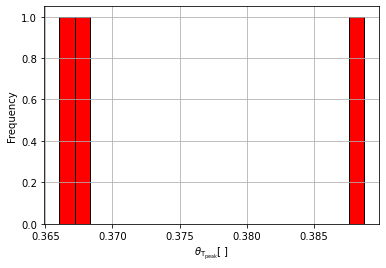

In [39]:
burn_in = int(accepted_thetas.shape[0]*0.9)
thetas_burned = accepted_thetas[burn_in:, :]
thetas_burned.shape
res = sc.norm.fit(thetas_burned[:,0])
print(res)
plt.hist(thetas_burned[:,0], bins=20, edgecolor='black', color = 'red')
plt.xlabel(r'$\theta_{\rm T_{peak}}  [\;]$')
plt.ylabel(r'Frequency')
plt.grid(True)

# Show the plot
plt.show()